<a href="https://colab.research.google.com/github/rennydoig/ssc22-case-comp/blob/main/Daisy_dir/The_mixed_effect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import csv
!pip install geopandas rtree
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pickle
import datetime
drive.mount('/content/drive')

     |████████████████████████████████| 1.0 MB 16.9 MB/s 
     |████████████████████████████████| 1.0 MB 64.2 MB/s 
     |████████████████████████████████| 16.7 MB 49.0 MB/s 
     |████████████████████████████████| 6.3 MB 20.9 MB/s 
Mounted at /content/drive


# The mixed effects model

The mixed effects model Yij = β0 + β1Tij + Vi + ϵij, where
*   Yij: download/upload speed for subject j in cluster i
*   Tij: time (fixed effect)
*   Vi: cluster-specific random effect such that Vi ~ N(0, Σ)
*   ϵij: subject-specific random effect such that eij ~ N(0, σ^2I) 

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Residual plot
# performance = pd.DataFrame()
# performance["residuals"] = result.resid.values
# performance["actual"] = data_train['avg_u_mbps']
# performance["fitted"] = result.fittedvalues
# ax = sns.residplot(x = "fitted", y = "residuals", data = performance, lowess=True)
# ax.set(ylabel='residuals')
# plt.show()

def mixedEffctModel(data, formula, random_effect, random_intercept=False, re_formula=None):
  if random_intercept:
    model = smf.mixedlm(formula, data_train, groups=data_train[random_effect], re_formula=re_formula)
    #free = sm.regression.mixed_linear_model.MixedLMParams.from_components(np.ones(2), np.eye(2))
  else: 
    model = smf.mixedlm(formula, data_train, groups=data_train[random_effect])

  result = model.fit()
  print(result.summary())
  return result

def makePrediction(true, model_fit, random_effect, random_intercept=False):
  fix_eff_pred = result.predict(exog=data_test)
  
  # The prediction on random effects
  ran_eff_pred = []

  if random_intercept:
    for i in range(data_test.shape[0]):
      x = data_test['CDNAME'].iloc[i]
      t = data_test['Time'].iloc[i]
      p = result.random_effects[x][0]+t*result.random_effects[x][1]
      ran_eff_pred.append(p)

    # Add the fixed and random effects to get the overall prediction
    pred = fix_eff_pred + ran_eff_pred
  else:
      for i in range(data_test.shape[0]):
        x = data_test[random_effect].iloc[i]
        ran_eff_pred.append(result.random_effects[x])

      # Add the fixed and random effects to get the overall prediction
      pred = fix_eff_pred + np.concatenate(ran_eff_pred)

  # Get RMSE
  print("RMSE: {}".format(np.sqrt(metrics.mean_squared_error(true, pred))))

  # Get accuracy
  pred_class = [int(p >= 50) for p in pred]
  true_class = [int(p >= 50) for p in true]
  print("Accuracy: {}".format(accuracy_score(true_class, pred_class, normalize=False)/float(len(true_class))))

  # Get confusion matrix
  print(metrics.confusion_matrix(true_class, pred_class))

  # Get classification report
  print(classification_report(true_class,pred_class))


def makeData(df,groups,conn_type):
  df['avg_d_mbps'] = df['avg_d_kbps'] / 1000
  df['avg_u_mbps'] = df['avg_u_kbps'] / 1000

  df['YQ'] = ["-".join(i) for i in zip(df['year'].astype(str), df['quarter'])]
  t_vals = sorted(df['YQ'].unique()) # sorts year-quarter values
  t_ints = [*range(1,len(t_vals)+1)] # creates a list of integers [1, 2, ...]
  df['Time'] = df['YQ'].replace(to_replace=t_vals, value=t_ints)

  # Filter only rural areas: rows with NaN for either PCUID, PCNAME, PCTYPE, or PCCLASS
  cond = (df['PCUID'].isna()) | (df['PCNAME'].isna()) | (df['PCTYPE'].isna()) | (df['PCCLASS'].isna())
  df_rural = df[cond]
  data = dataAggregation(df,groups,conn_type)
  maxTime = data['Time'].max()
  data_train = data[data['Time'] < maxTime]
  data_test = data[data['Time'] == maxTime]
  return data_train, data_test


def dataAggregation(df, aggregate_by, conType):
    """ Aggregate data by tile, dissemination area, census division or province """
    '''
    df: orginal data in pd.DataFrame
    aggregate_by: 'quadkey' or 'DAUID' or 'CDNAME' or "PRNAME"
    conType: boolen, has the option to seperate connect type (e.g. fixed or mobile)
    '''

    # Weighted average of 'avg_d_mbps', 'avg_u_mbps' and 'avg_lat_ms', weight = 'tests'
    wm = lambda x: np.average(x, weights=df.loc[x.index, 'tests'])

    if conType:
      dat = df.groupby([aggregate_by,'Time','conn_type'],as_index=False).agg({"avg_u_mbps":wm,
                                                                              "avg_d_mbps":wm,
                                                                              "avg_lat_ms":wm,
                                                                              "tests":"sum"})
    else: 
      dat = df.groupby([aggregate_by,'Time'],as_index=False).agg({"avg_u_mbps":wm,
                                                                  "avg_d_mbps":wm,
                                                                  "avg_lat_ms":wm,
                                                                  "tests":"sum"})

    return dat

In [11]:
os.chdir('/content/drive/MyDrive/2022 SSC Case Study/dataset/')
with open('./cd-w-avg-with-dist.p', 'rb') as file:
  df = pickle.load(file)

In [49]:
t_vals = sorted(df['time'].unique()) # sorts year-quarter values
t_ints = [*range(1,len(t_vals)+1)] # creates a list of integers [1, 2, ...]
df['Time'] = df['time'].replace(to_replace=t_vals, value=t_ints)

maxTime = df['Time'].max()
data_train = df[df['Time'] < maxTime] # all the observations except the last one are training set
data_test = df[df['Time'] == maxTime] # the last obseravtion is test set
data_train

,PRUID,CDUID,avg_lat_ms,distance,SACTYPE,DA_POP,devices,tests,geometry,conn_type,time,avg_d_mbps,avg_u_mbps,Time
0,61,6101.0,36.755102,6.425546,8.000000,448.265306,19.0,49.0,"MULTIPOLYGON (((4642490.038 4066985.206, 46426...",fixed,2019-Q1,14.574776,5.991551,1
1,61,6102.0,28.585366,444.526332,8.000000,747.073171,16.0,41.0,"MULTIPOLYGON (((4695765.369 3628102.680, 46958...",fixed,2019-Q1,26.693902,3.160341,1
2,61,6103.0,324.200000,104.673055,8.000000,330.000000,3.0,5.0,"MULTIPOLYGON (((5032382.179 3158440.088, 50322...",fixed,2019-Q1,11.964200,0.841000,1
3,61,6104.0,24.850000,306.145252,8.000000,739.250000,15.0,40.0,"MULTIPOLYGON (((4567677.409 3073390.226, 45678...",fixed,2019-Q1,9.468550,1.158050,1
4,61,6106.0,29.559838,9.110629,3.212982,630.091278,240.0,493.0,"MULTIPOLYGON (((5094536.880 3094447.671, 50944...",fixed,2019-Q1,52.260937,7.403355,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,62,6204.0,43.071429,0.009375,8.000000,2559.821429,14.0,28.0,"MULTIPOLYGON (((7292387.428 3241679.826, 72921...",mobile,2021-Q1,44.356071,10.217607,9
0,62,6204.0,37.244898,0.058935,8.000000,2660.102041,26.0,49.0,"MULTIPOLYGON (((7292821.313 3241284.005, 72925...",fixed,2021-Q2,12.798102,1.576551,10
0,62,6204.0,22.880000,0.183896,8.000000,2436.100000,17.0,50.0,"MULTIPOLYGON (((7292821.313 3241284.005, 72927...",mobile,2021-Q2,32.714600,7.122600,10
0,62,6204.0,10.702128,0.068872,8.000000,2819.042553,44.0,94.0,"MULTIPOLYGON (((7291442.712 3240472.949, 72916...",fixed,2021-Q3,12.543915,2.334309,11


Response: avg_u_mbps \\
Fixed effect: Time + conn_type + devices + DA_POP + SACTYPE \\
Randome effect: CDUID



In [73]:
result = mixedEffctModel(data_train, 'avg_u_mbps ~ Time + conn_type + devices + DA_POP + SACTYPE', 'CDUID')
makePrediction(data_test['avg_u_mbps'], result, 'CDUID')

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    avg_u_mbps 
No. Observations:    6369       Method:                REML       
No. Groups:          293        Scale:                 175.7075   
Min. group size:     2          Likelihood:            -25903.2450
Max. group size:     22         Converged:             Yes        
Mean group size:     21.7                                         
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            33.315    1.989  16.748 0.000  29.417  37.214
conn_type[T.mobile] -19.112    0.355 -53.801 0.000 -19.808 -18.416
Time                  1.055    0.053  20.055 0.000   0.952   1.158
devices               0.000    0.000   5.667 0.000   0.000   0.000
DA_POP                0.002    0.001   1.291 0.197  -0.001   0.004
SACTYPE   

Text(0.5, 1.0, 'Upload speed trend over time for CSD=4808')

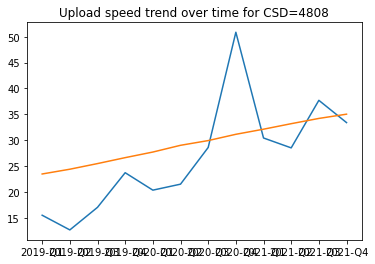

In [54]:
## Take only one CSD (PRUID=48 (Alberta) and conn_type = 'fixed') as an example.
ab_data = df[(df['PRUID'] == 48) & (df['conn_type'] == 'fixed')]
ab_data2 = ab_data[ab_data['CDUID']==4807].sort_values(by='time')
plot_x = ab_data2['time']
plot_y = ab_data2['avg_u_mbps']

fix_eff_pred = result.predict(exog=ab_data2)
ran_eff_pred = []
for i in range(ab_data2.shape[0]):
    x = ab_data2['CDUID'].iloc[i]
    ran_eff_pred.append(result.random_effects[x])
pred = fix_eff_pred + np.concatenate(ran_eff_pred)
ab_data2['pred'] = pred

plt.plot(plot_x, plot_y)
plt.plot(ab_data2['time'], ab_data2['pred'])
plt.title('Upload speed trend over time for CSD={csd}'.format(csd = 4808))

Response: avg_d_mbps \\
Fixed effect: Time + conn_type + devices + DA_POP + SACTYPE \\
Randome effect: CDUID

In [69]:
result = mixedEffctModel(data_train, 'avg_d_mbps ~ Time + conn_type + devices + DA_POP + SACTYPE', 'CDUID')
makePrediction(data_test['avg_d_mbps'], result, 'CDUID')

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    avg_d_mbps 
No. Observations:    6369       Method:                REML       
No. Groups:          293        Scale:                 448.1702   
Min. group size:     2          Likelihood:            -28914.1409
Max. group size:     22         Converged:             Yes        
Mean group size:     21.7                                         
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            82.033    3.364  24.386 0.000  75.440  88.626
conn_type[T.mobile] -14.233    0.569 -25.025 0.000 -15.348 -13.118
Time                  3.493    0.084  41.576 0.000   3.329   3.658
devices               0.000    0.000   6.390 0.000   0.000   0.001
DA_POP                0.008    0.002   4.320 0.000   0.005   0.012
SACTYPE   

Text(0.5, 1.0, 'Download speed trend over time for CSD=4808')

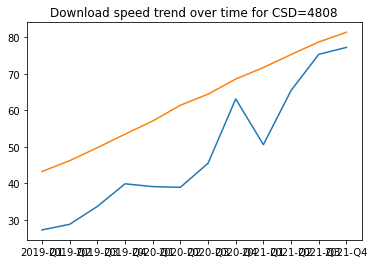

In [56]:
## Take only one CSD (PRUID=48 (Alberta) and conn_type = 'fixed') as an example.
ab_data = df[(df['PRUID'] == 48) & (df['conn_type'] == 'fixed')]
ab_data2 = ab_data[ab_data['CDUID']==4807].sort_values(by='time')
plot_x = ab_data2['time']
plot_y = ab_data2['avg_d_mbps']

fix_eff_pred = result.predict(exog=ab_data2)
ran_eff_pred = []
for i in range(ab_data2.shape[0]):
    x = ab_data2['CDUID'].iloc[i]
    ran_eff_pred.append(result.random_effects[x])
pred = fix_eff_pred + np.concatenate(ran_eff_pred)
ab_data2['pred'] = pred

plt.plot(plot_x, plot_y)
plt.plot(ab_data2['time'], ab_data2['pred'])
plt.title('Download speed trend over time for CSD={csd}'.format(csd = 4808))

Response: avg_lat_ms \\
Fixed effect: Time + conn_type + devices + DA_POP + SACTYPE \\
Randome effect: CDUID

In [77]:
result = mixedEffctModel(data_train, 'avg_lat_ms ~ Time + conn_type + devices + DA_POP + SACTYPE', 'CDUID')
makePrediction(data_test['avg_lat_ms'], result, 'CDUID')

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   avg_lat_ms 
No. Observations:    6369      Method:               REML       
No. Groups:          293       Scale:                543.5656   
Min. group size:     2         Likelihood:           -29533.6937
Max. group size:     22        Converged:            Yes        
Mean group size:     21.7                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            35.576    3.742   9.507 0.000 28.242 42.911
conn_type[T.mobile]   2.834    0.626   4.524 0.000  1.607  4.062
Time                 -1.180    0.093 -12.753 0.000 -1.361 -0.999
devices              -0.000    0.000  -5.735 0.000 -0.001 -0.000
DA_POP               -0.006    0.002  -2.664 0.008 -0.010 -0.002
SACTYPE               5.480    0.679   

Text(0.5, 1.0, 'Latency trend over time for CSD=4808')

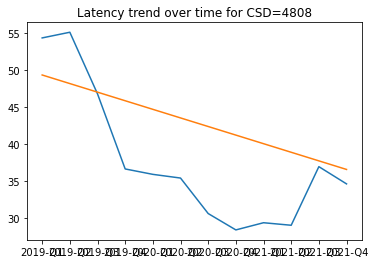

In [66]:
## Take only one CSD (PRUID=48 (Alberta) and conn_type = 'fixed') as an example.
ab_data = df[(df['PRUID'] == 48) & (df['conn_type'] == 'fixed')]
ab_data2 = ab_data[ab_data['CDUID']==4807].sort_values(by='time')
plot_x = ab_data2['time']
plot_y = ab_data2['avg_lat_ms']

fix_eff_pred = result.predict(exog=ab_data2)
ran_eff_pred = []
for i in range(ab_data2.shape[0]):
    x = ab_data2['CDUID'].iloc[i]
    ran_eff_pred.append(result.random_effects[x])
pred = fix_eff_pred + np.concatenate(ran_eff_pred)
ab_data2['pred'] = pred

plt.plot(plot_x, plot_y)
plt.plot(ab_data2['time'], ab_data2['pred'])
plt.title('Latency trend over time for CSD={csd}'.format(csd = 4808))